# Predicción del precio futuro de ethereum



In [65]:
import pandas as pd 
import numpy as np # numpy y pandas to data wrangling 
from datetime import datetime, timedelta # to work w date
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import math

## Regresión lineal 
En esta sección se desarrolla el primer modelo de predicción: la regresión lineal múltiple, que tiene como función objetivo el error cuadrático medio y se optimiza mediante mínimos cuadrados ordinarios (OLS). 

Si bien es un modelo simple dentro del abanico de estimadores de machine learning, el método de regresión lineal resulta competitivo en la práctica y presenta ventajas en la facilidad para interpretar los resultados. De esta forma, el trabajo comienza el ejercicio de predicción con OLS para luego pasar a modelos más sofisticados. 

La sección se estructura de la siguiente manera. En primer lugar, ajustamos y evaluamos la performance del modelo, utilizando una separación básica de train y test siguiendo el enfoque de validación. Luego, realizamos un método de selección conocido como *forward stepwise selection*, que elige los predictores que mayor influencia tengan en la predicción, partiendo de un modelo sin *features* y avanzando uno a uno en variables hasta llegar al modelo con todas las independientes incluidas. Por último, el trabajo realiza la técnica de *k-folds-cross validation* bajo dos formas: la primera, conocida como *Time Series Split Cross-Validation* parte del segmento de observaciones más antiguo para entrenar y evaluar un segmento de observaciones contiguas en el tiempo. El proceso se repite acumulando observaciones al grupo de entrenamiento que en el proceso anterior eran parte del grupo de validación. La segunda forma se conoce como *Blocked Cross-Validation*, la diferencia con la forma anterior radica en que esta no acumula observaciones en entrenamiento, sino que siempre se renuevan los segmentos tanto de *train* como de validación. 

Por último, el análisis se enfocara en predecir la misma variable *target* pero en momentos distintos del tiempo. En total, son 7 variables a predecir, que van desde el rezago 1 hasta el rezago 7 de la cotización de ethereum. 

In [66]:
### Importamos bases
# train
aux = 'https://drive.google.com/file/d/1JgC5z_ed0YfAjuiYxl9SqqPvgxX3-cZs/view?usp=sharing'
link ='https://drive.google.com/uc?id=' + aux.split('/')[-2]
train = pd.read_csv(link)
train = train.set_index('Date')

# test
aux = 'https://drive.google.com/file/d/1GqALyVt4jKpkUoR2IbQJBvek4Y5rkEg-/view?usp=sharing'
link ='https://drive.google.com/uc?id=' + aux.split('/')[-2]
test = pd.read_csv(link)
test = test.set_index('Date')
# target en train 
aux = 'https://drive.google.com/file/d/1qWQobNkMKTZah0hKhMWiiI1rDy89NaN6/view?usp=sharing'
link ='https://drive.google.com/uc?id=' + aux.split('/')[-2]
y_train = pd.read_csv(link)
y_train = y_train.set_index('Date')
# target en test
aux = 'https://drive.google.com/file/d/1PhiVLaNQ3k7-XifEepwD4LoymDAmixix/view?usp=sharing'
link ='https://drive.google.com/uc?id=' + aux.split('/')[-2]
y_test = pd.read_csv(link)
y_test = y_test.set_index('Date')

### Entrenamiento del modelo 

In [67]:
#agregar constante
x_train = sm.add_constant(train)
x_test = sm.add_constant(test)

In [68]:
# ajuste lineal
model = sm.OLS(y_train.iloc[:,0], x_train.astype(float)).fit()
 
# view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             log_y_lag1   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.759e+05
Date:                Sun, 11 Sep 2022   Prob (F-statistic):               0.00
Time:                        08:38:47   Log-Likelihood:                 5852.8
No. Observations:                1956   AIC:                        -1.162e+04
Df Residuals:                    1911   BIC:                        -1.136e+04
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

En primer lugar estimamos una regresión lineal entre las predictoras de interés y el precio de ethereum rezagado 1 día, es decir, la cotización del siguiente día. En la salida de regresión se observan variables significativas esperables, como el precio de ethereum y de bitcoin del día corriente y anterior al corriente. En el caso de ethereum, la correlación parcial es positva, interpretándose que un aumento del 1% del precio actual de ethereum se correlaciona, ceteris paribus, con un aumento del 0.99% del precio de ethereum del día siguiente. Mientras que en caso del bitcoin existen dos efectos significativos: el del día corriente y del día anterior al actual. Un aumento del 1% del precio corriente de bitcoin se asocia con una caída del 0.8% del precio de ethereum del día siguiente. No obstante, un aumento del 1% del precio de bitcoin del día anterior al actual se correlaciona con un aumento del 0.84% del valor de ethereum. Resulta interesante como se contraponen ambos efectos. Si lo analizaramos en sentido estático y dejando todo lo demás constante, un aumento del precio de bitcoin en el día actual, seguido de un aumento de la misma criptomoneda en el día anterior, ambas de la misma variación porcentual, se correlacionaría con un leve aumento del precio de ethereum. Ambos efectos jugarían como un rol de sustituto (bitcoin en el día actual) por un lado y complementario (bitcoin del día anterior al actual), por el otro, del valor del siguiente día de ethereum.   

Resulta también interesante que el ajuste sea de 1, tanto observando el R2 como el R2 ajustado. En base a esto surge la pregunta de si dicho ajuste se mantendría al estimar valores de ethereum más lejanos en el tiempo.  

In [69]:
r_squaredAdj = []
for i in range(1,len(y_train.columns)+1):
  model = sm.OLS(y_train.loc[:,f'log_y_lag{i}'], x_train.astype(float)).fit()
  r_squaredAdj = r_squaredAdj + [round(model.rsquared, 4)]

In [70]:
r_squaredAdj

[0.9998, 0.9988, 0.9979, 0.997, 0.9961, 0.9951, 0.9942]

El bucle anterior extrae de cada regresión entre el valor de ethreum de difentes momentos en el tiempo el R2 ajustado, partiendo desde el primer rezago hasta el séptimo. El ajuste, si bien disminuye al ajustar un modelo que estima momentos más lejanos en el tiempo, sigue siendo considerablemente alto en todas las instancias. 

### Evaluación performance en el grupo de entrenamiento
Primero evaluamos la performance predictiva en el grupo de entrenamiento, siendo conscientes del probable sobreajuste que esta evaluación genere. Para realizar la evluación de desempeño del modelo utilizamos como métrica la raíz del error cuadrático medio como proporción de la media del target. Esto último para poder tener mayor claridad a la hora de interpretar los resultados.

In [7]:
# computamos el predicho para cada uno de los rezagos de la dependiente
predictions_dict = {}
for i in range(1,len(y_train.columns)+1):
  model = sm.OLS(y_train.loc[:,f'log_y_lag{i}'], x_train.astype(float)).fit()
  predictions = model.predict()
  predictions_dict[f'pred_y_lag{i}'] = predictions

In [8]:
for i in range(1,len(y_train.columns)+1):
  mse = mean_squared_error(y_train.loc[:,f'log_y_lag{i}'], 
                           predictions_dict[f'pred_y_lag{i}'])
  rmse = math.sqrt(mse)
  mean_target_train = y_train.loc[:,f'log_y_lag{i}'].mean()
  print(f"Raíz del error cuadrático medio para log_y_lag{i}:")
  print(f'El error de predicción en el grupo de entrenamiento es equivalente al {round(rmse/mean_target_train*100)}% del promedio de la variable dependiente\n')

Raíz del error cuadrático medio para log_y_lag1:
El error de predicción en el grupo de entrenamiento es equivalente al 1% del promedio de la variable dependiente

Raíz del error cuadrático medio para log_y_lag2:
El error de predicción en el grupo de entrenamiento es equivalente al 1% del promedio de la variable dependiente

Raíz del error cuadrático medio para log_y_lag3:
El error de predicción en el grupo de entrenamiento es equivalente al 2% del promedio de la variable dependiente

Raíz del error cuadrático medio para log_y_lag4:
El error de predicción en el grupo de entrenamiento es equivalente al 2% del promedio de la variable dependiente

Raíz del error cuadrático medio para log_y_lag5:
El error de predicción en el grupo de entrenamiento es equivalente al 2% del promedio de la variable dependiente

Raíz del error cuadrático medio para log_y_lag6:
El error de predicción en el grupo de entrenamiento es equivalente al 3% del promedio de la variable dependiente

Raíz del error cuadrát

Como es esperable, el ajuste es considerablemente alto, por lo que la predicción también lo es. Aunque la performance disminuye a medida que predecimos valores más lejanos.

### Evaluación performance en el grupo de test
Pasamos a evaluar la performance en el grupo test. 

In [9]:
predictions_test_dict = {}
for i in range(1,len(y_test.columns)+1):
  model = sm.OLS(y_train.loc[:,f'log_y_lag{i}'], x_train.astype(float)).fit()
  predictions = model.predict(x_test)
  predictions_test_dict[f'pred_y_lag{i}'] = predictions

In [76]:
for i in range(1,len(y_test.columns)+1):
  mse = mean_squared_error(y_test.loc[:,f'log_y_lag{i}'], 
                           predictions_test_dict[f'pred_y_lag{i}'])
  rmse = math.sqrt(mse)
  mean_target_test = y_test.loc[:,f'log_y_lag{i}'].mean()
  print(f"Raíz del error cuadrático medio para log_y_lag{i} en test:")
  print(f'El error de predicción es equivalente al {round(rmse/mean_target_test*100,2)}% del promedio de la variable dependiente\n')

Raíz del error cuadrático medio para log_y_lag1 en test:
El error de predicción es equivalente al 0.36% del promedio de la variable dependiente

Raíz del error cuadrático medio para log_y_lag2 en test:
El error de predicción es equivalente al 0.84% del promedio de la variable dependiente

Raíz del error cuadrático medio para log_y_lag3 en test:
El error de predicción es equivalente al 1.2% del promedio de la variable dependiente

Raíz del error cuadrático medio para log_y_lag4 en test:
El error de predicción es equivalente al 1.52% del promedio de la variable dependiente

Raíz del error cuadrático medio para log_y_lag5 en test:
El error de predicción es equivalente al 1.84% del promedio de la variable dependiente

Raíz del error cuadrático medio para log_y_lag6 en test:
El error de predicción es equivalente al 2.08% del promedio de la variable dependiente

Raíz del error cuadrático medio para log_y_lag7 en test:
El error de predicción es equivalente al 2.27% del promedio de la variable

Curiosamente, la performance predictiva tiene mejoras en el grupo test respecto a la evaluación en el grupo de entrenamiento. A continuación, pasamos a graficar el observado versus el predicho para cada target estimado.

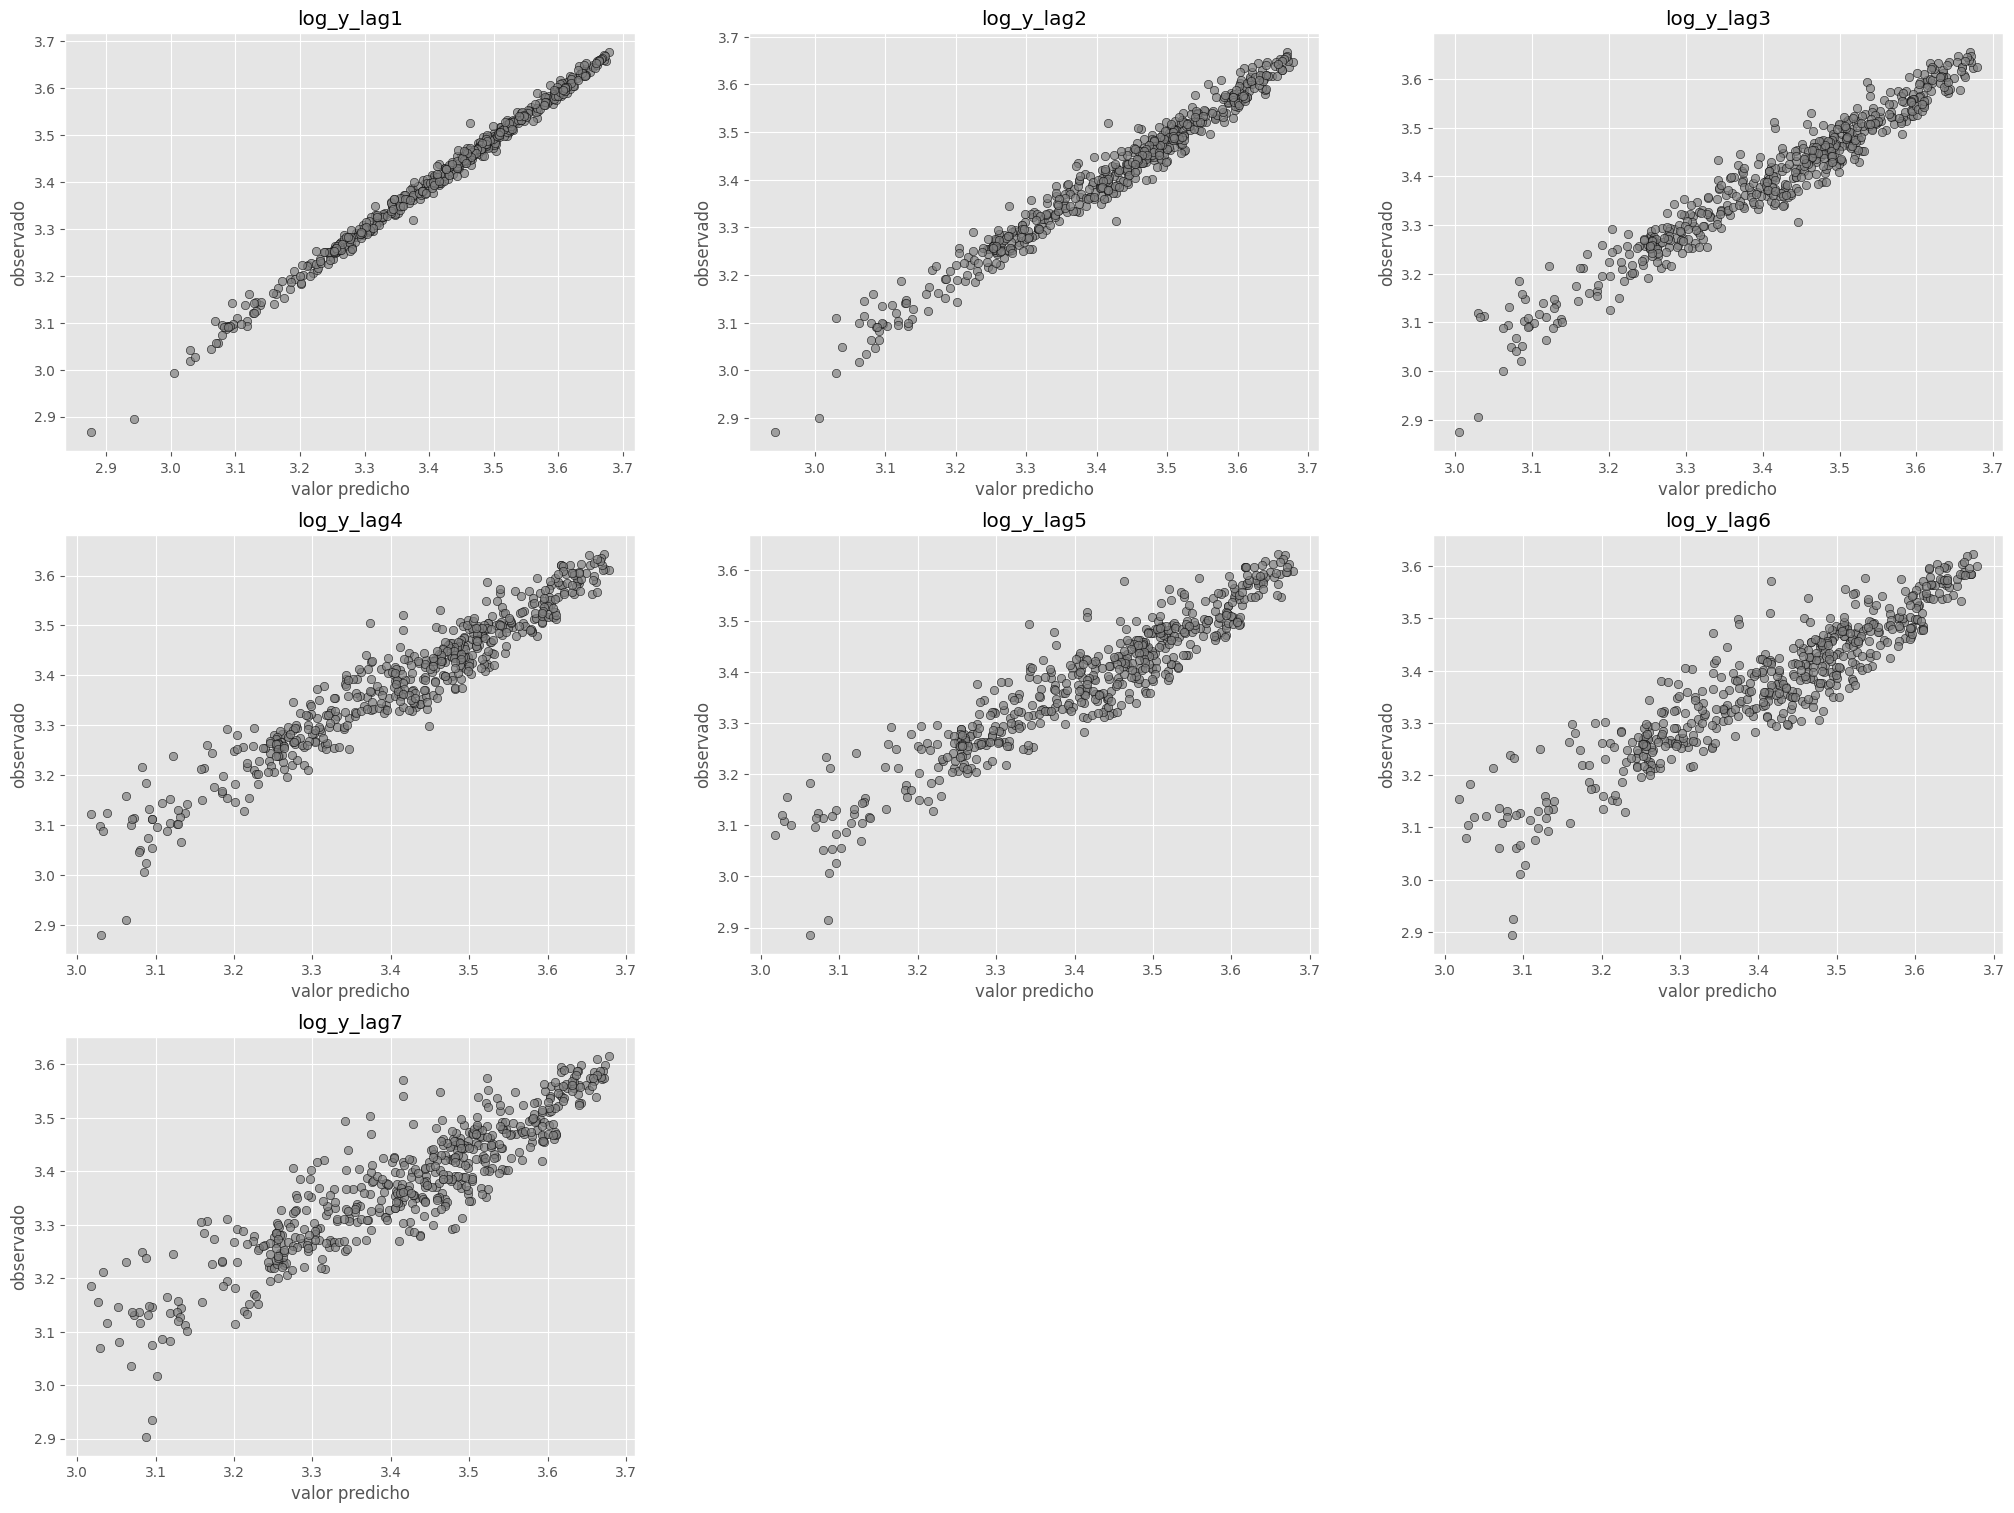

In [49]:
plt.style.use('default')
plt.style.use('ggplot')

fig=plt.figure(figsize=(25,25))
for i in range(0,7):
    ax=fig.add_subplot(4,3, i+1)
    ax.scatter(y_test.loc[:,f'log_y_lag{i+1}'], 
               predictions_test_dict[f'pred_y_lag{i+1}'], 
               edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
    plt.title(f'log_y_lag{i+1}')
    plt.xlabel("valor predicho")
    plt.ylabel("observado")

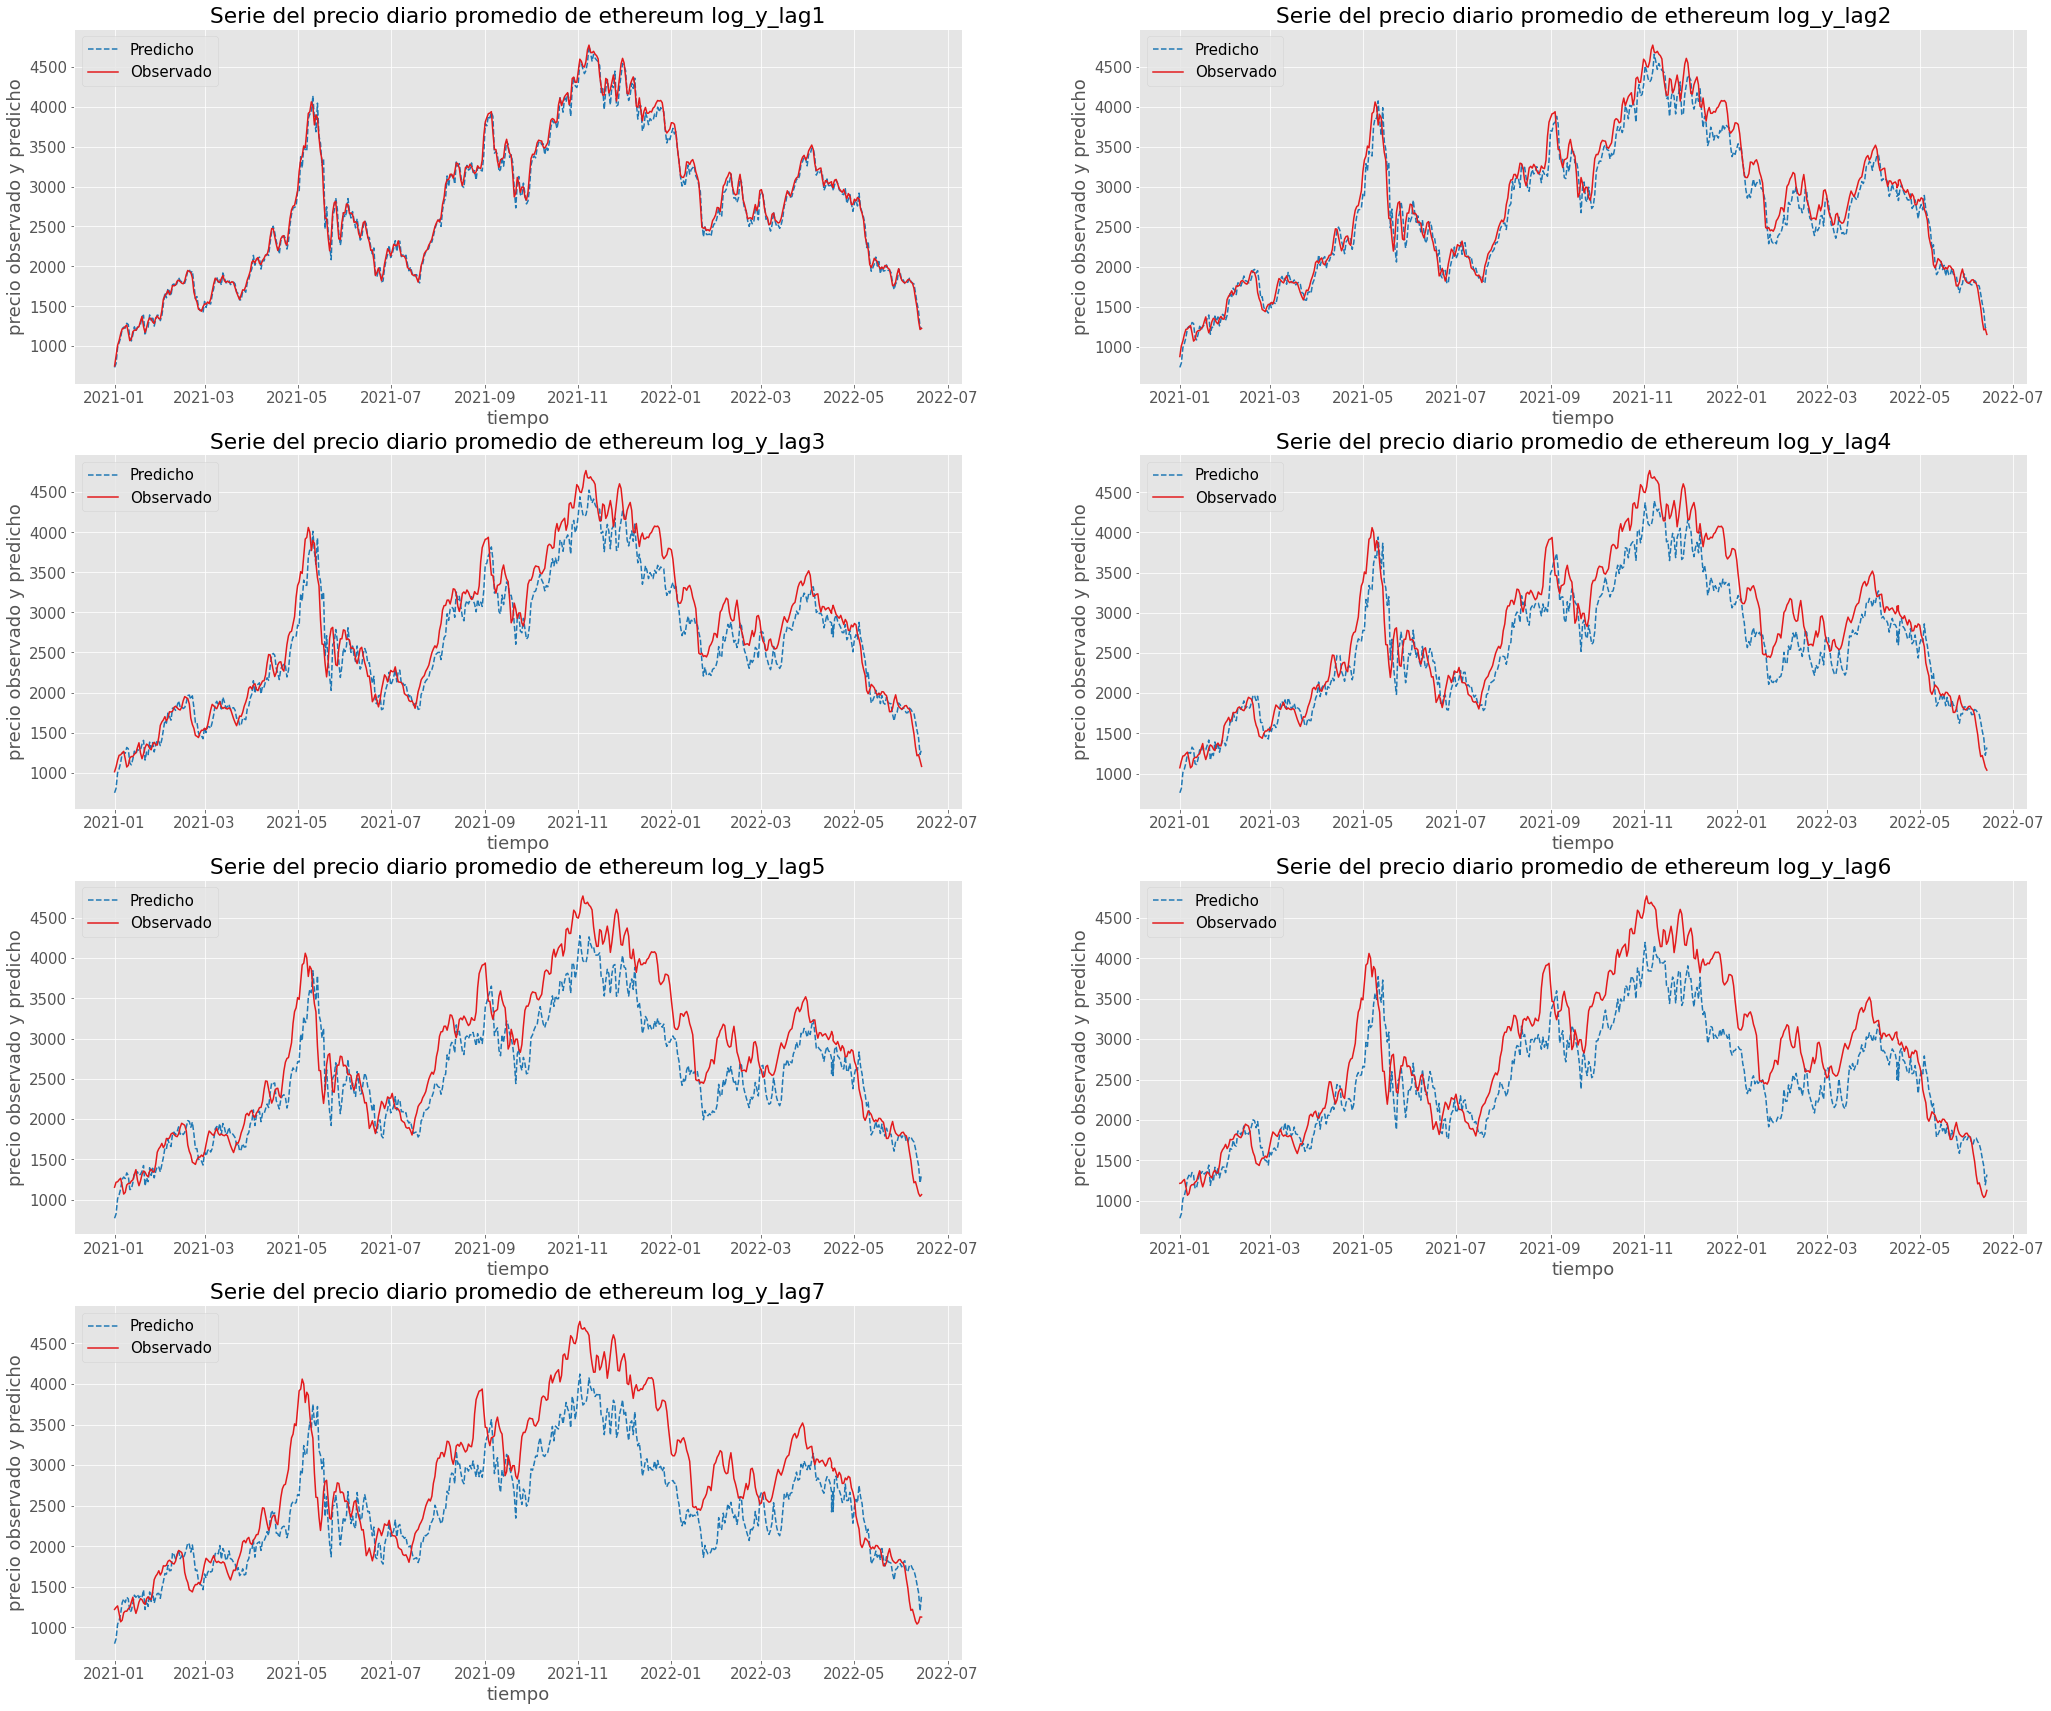

In [64]:
## graficamos el predicho versus el observado en cotizaciones
mpl.style.use('ggplot') # set estilo
mpl.rcParams.update({'font.size': 15}) # set tamaño de ticks

fig=plt.figure(figsize=(35,30))
for i in range(0,7):
    pred_exp = 10**(predictions_test_dict[f'pred_y_lag{i+1}'])
    observ_exp = 10**(y_test.loc[:,f'log_y_lag{i+1}'])
    pred_exp.index = pd.to_datetime(pred_exp.index)
    observ_exp.index = pd.to_datetime(observ_exp.index)
    ax=fig.add_subplot(4,2, i+1)
    ax.plot(pred_exp, color='#1f78b4', label = 'Predicho', linestyle="--")
    ax.plot(observ_exp , color='#e31a1c', label = 'Observado')
    plt.ylabel("precio observado y predicho")
    plt.xlabel("tiempo")
    plt.title(f'Serie del precio diario promedio de ethereum log_y_lag{i+1}')
    plt.legend(loc="upper left");

Como se puede ver, la dispersión entre el valor real y el estimado aumenta a medida que tratamos de predecir ventanas de tiempo más lejanas al período actual. No obstante, la performance se mantiene alta inclusive a la hora de predecir el valor de ethereum del mismo día de la semana siguiente al actual.

### Forward stepwise selection

Por simplicidad, para el caso de selección y validación cruzada se utilizará solamente el precio de ethereum rezagado siete días. 

In [53]:
# x_test_step = sm.add_constant(test)
candidates = list(train.columns)

seleccionado = []
# output_df = pd.DataFrame(d)
train_step = sm.add_constant(train)
test_step = sm.add_constant(test)

# baseline
model_baseline = sm.OLS(y_train.loc[:,'log_y_lag7'], train_step.loc[:,'const'].astype(float)).fit()
# predicción
predictions_test_baseline = model_baseline.predict(test_step.loc[:,'const'])
# métrica
mse_test_baseline = mean_squared_error(y_test.loc[:,'log_y_lag7'], predictions_test_baseline)
rmse_test_baseline = math.sqrt(mse_test_baseline)/y_test.loc[:,'log_y_lag7'].mean()
# df
d = {'var': ["constant"], 'rmse': [rmse_test_baseline]}
output_df = pd.DataFrame(data=d)

# selección
c = 0
while len(candidates) > 0:
  max_rmse = float('inf') 
  for v in candidates:
    # agregar constante
    l =  seleccionado + [v] + ['const']
    # subset
    x_train_step = train_step.loc[:, l]
    x_test_step = test_step.loc[:, l]
    
    # ajuste lineal
    model_step = sm.OLS(y_train.loc[:,'log_y_lag7'], x_train_step.astype(float)).fit()
    # predicción
    predictions_test_step = model_step.predict(x_test_step)
    # métrica
    mse_test_step = mean_squared_error(y_test.loc[:,'log_y_lag7'], predictions_test_step)
    rmse_test_step = math.sqrt(mse_test_step)/y_test.loc[:,'log_y_lag7'].mean()
    if rmse_test_step < max_rmse:
      max_rmse = rmse_test_step
      to_add = v
  candidates.remove(to_add)
  seleccionado.append(to_add)
  output_df = output_df.append(pd.DataFrame({'var': [to_add], 'rmse': [max_rmse]}), ignore_index = True)
  print(output_df)
  c = c + 1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


             var      rmse
0       constant  0.428433
1  log_price_eth  0.016584
                        var      rmse
0                  constant  0.428433
1             log_price_eth  0.016584
2  bitcoin_top_adjusted_log  0.016368
                        var      rmse
0                  constant  0.428433
1             log_price_eth  0.016584
2  bitcoin_top_adjusted_log  0.016368
3     pandemic_adjusted_log  0.016269
                        var      rmse
0                  constant  0.428433
1             log_price_eth  0.016584
2  bitcoin_top_adjusted_log  0.016368
3     pandemic_adjusted_log  0.016269
4        china_adjusted_log  0.016137
                          var      rmse
0                    constant  0.428433
1               log_price_eth  0.016584
2    bitcoin_top_adjusted_log  0.016368
3       pandemic_adjusted_log  0.016269
4          china_adjusted_log  0.016137
5  united states_adjusted_log  0.016080
                          var      rmse
0                    constant

In [54]:
output_df

,var,rmse
0,constant,0.428433
1,log_price_eth,0.016584
2,bitcoin_top_adjusted_log,0.016368
3,pandemic_adjusted_log,0.016269
4,china_adjusted_log,0.016137
5,united states_adjusted_log,0.016080
6,russia_adjusted_log,0.016039
7,log_price_btc,0.016018
8,fed_adjusted_log,0.015992
9,investment_top_adjusted_log,0.015970


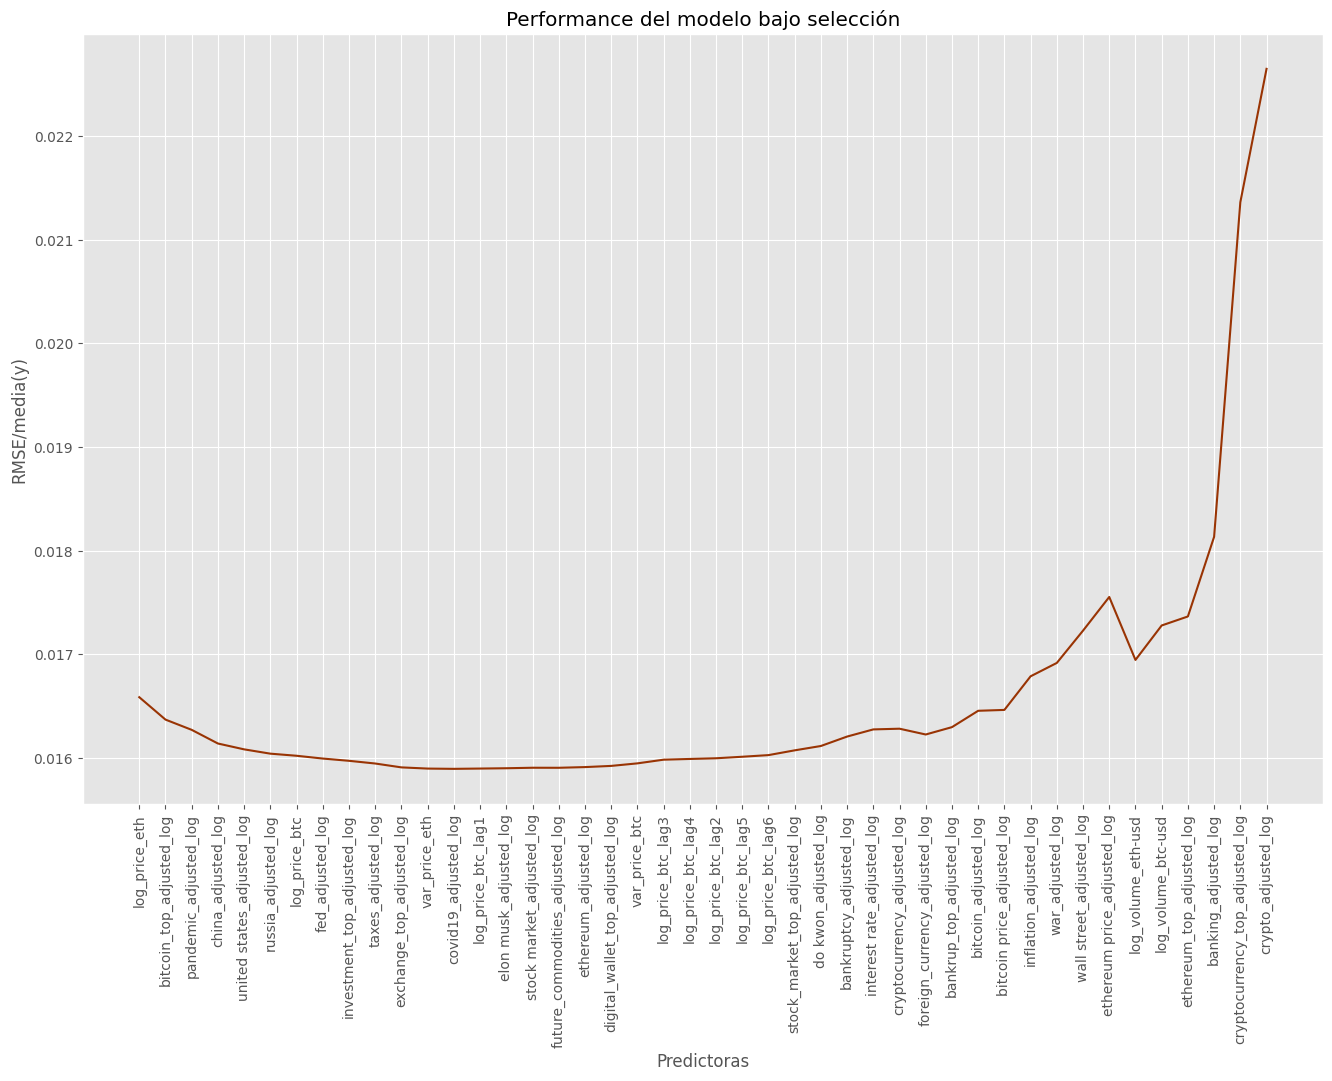

In [61]:
mpl.rcParams.update({'font.size': 10}) # set tamaño de ticks
# graficamos la base ethereum completa
# train.index = pd.to_datetime(train.index)
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(output_df.loc[1:,'var'], output_df.loc[1:,'rmse'], color='#993404') # sacamos la constante para mejorar la visibilidad
plt.ylabel("RMSE/media(y)")
plt.xlabel("Predictoras")
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.title("Performance del modelo bajo selección");

### K-folds-cross-validation
*cross-validation* representa una técnica para validar el modelo separando el conjunto de datos en K grupos, donde para todos estos se realiza entrenamiento y validación. El entrenamiento con todos los datos excepto los pertenecientes a un grupo en cuestión, y se valida la predicción con ese subconjunto dejado afuera. El proceso se repite la cantidad de veces según cantidad de grupos exista. 

El ejericio se realiza utilizando el subconjunto entrenamiento para la formación de grupos.  

#### Time Series Split Cross-Validation

In [71]:
def date_range(start, end, intv):
    start = datetime.strptime(start,"%Y-%m-%d")
    end = datetime.strptime(end,"%Y-%m-%d")
    diff = (end  - start ) / intv
    for i in range(intv):
        yield (start + diff * i).strftime("%Y-%m-%d")
    yield end.strftime("%Y-%m-%d")

In [72]:
lower = x_train.index[0]
upper = x_train.index[-1]
timelist = list(date_range(lower, upper, 11))
timelist

['2015-08-17',
 '2016-02-11',
 '2016-08-07',
 '2017-02-02',
 '2017-07-30',
 '2018-01-25',
 '2018-07-22',
 '2019-01-17',
 '2019-07-14',
 '2020-01-09',
 '2020-07-05',
 '2020-12-31']

In [73]:
rmse_matrix_train = []
rmse_matrix_valid = []
for i in range(1, len(timelist)-1):
  first = timelist[0]
  last = timelist[i]
  aux = datetime.strptime(last,"%Y-%m-%d") + timedelta(days=1)
  first_valid = aux.strftime("%Y-%m-%d")
  last_valid = timelist[i+1]
  print(f'Iteration {i} working on range of date {first} to {last} (training) to predict range {first_valid} to {last_valid}')
  x_train_cv = x_train[first:last]
  x_valid_cv = x_train[first_valid:last_valid]
  y_train_cv = y_train.loc[:,'log_y_lag1'][first:last]
  y_valid_cv = y_train.loc[:,'log_y_lag1'][first_valid:last_valid]
  model_cv = sm.OLS(y_train_cv, x_train_cv.astype(float)).fit()
  # Prueba en observaciones usadas para ajustar
  predictions_train_cv = model.predict(x_train_cv)
  mse_train_cv = mean_squared_error(y_train_cv, predictions_train_cv)
  rmse_train_cv = math.sqrt(mse_train_cv)
  mean_target_cv_train = y_train_cv.mean()
  metric_error_train = rmse_train_cv/mean_target_cv_train*100
  rmse_matrix_train.append(metric_error_train)
  # prueba en observaciones del grupo dejado afuera
  predictions_valid_cv = model.predict(x_valid_cv)
  mse_valid_cv = mean_squared_error(y_valid_cv, predictions_valid_cv)
  rmse_valid_cv = math.sqrt(mse_valid_cv)
  mean_target_cv = y_valid_cv.mean()
  metric_error_valid = rmse_valid_cv/mean_target_cv*100
  print(f'  El error de predicción representa el {round(metric_error_train, 2)}% de la media en entrenamiento y el {round(metric_error_valid, 2)}% en validación\n')
  rmse_matrix_valid.append(metric_error_valid)

Iteration 1 working on range of date 2015-08-17 to 2016-02-11 (training) to predict range 2016-02-12 to 2016-08-07
  El error de predicción representa el 8.05% de la media en entrenamiento y el 2.49% en validación

Iteration 2 working on range of date 2015-08-17 to 2016-08-07 (training) to predict range 2016-08-08 to 2017-02-02
  El error de predicción representa el 3.76% de la media en entrenamiento y el 2.72% en validación

Iteration 3 working on range of date 2015-08-17 to 2017-02-02 (training) to predict range 2017-02-03 to 2017-07-30
  El error de predicción representa el 3.31% de la media en entrenamiento y el 2.27% en validación

Iteration 4 working on range of date 2015-08-17 to 2017-07-30 (training) to predict range 2017-07-31 to 2018-01-25
  El error de predicción representa el 2.93% de la media en entrenamiento y el 1.28% en validación

Iteration 5 working on range of date 2015-08-17 to 2018-01-25 (training) to predict range 2018-01-26 to 2018-07-22
  El error de predicción 

In [74]:
# vemos los resultados en validación para cada iteración
rmse_matrix_valid

[2.4941522266641267,
 2.7249460977753173,
 2.269967558511233,
 1.2766187626074974,
 0.9926973246945384,
 1.176709950144632,
 0.904918740526607,
 0.8317127192911236,
 1.112305455898825,
 0.9857715928647285]

In [75]:
# promediamos los errores en validación de cada iteración
def Average(lst):
    return sum(lst) / len(lst)

mean_error_cv_valid = Average(rmse_matrix_valid)
mean_error_cv_train = Average(rmse_matrix_train)

print(f'En promedio, la predicción arroja un error del {round(mean_error_cv_train, 2)}% de la media en entrenamiento y el {round(mean_error_cv_valid, 2)}% en validación')

En promedio, la predicción arroja un error del 2.88% de la media en entrenamiento y el 1.48% en validación


#### Blocked Cross-Validation

In [70]:
rmse_matrix_train_blocked = []
rmse_matrix_valid_blocked = []
for i in range(0, len(timelist)-2):
  first = timelist[i]
  last = timelist[i+1]
  aux = datetime.strptime(last,"%Y-%m-%d") + timedelta(days=1)
  first_valid = aux.strftime("%Y-%m-%d")
  last_valid = timelist[i+2]
  print(f'Iteration {i} working on range of date {first} to {last} (training) to predict range {first_valid} to {last_valid}')
  x_train_cv = x_train[first:last]
  x_valid_cv = x_train[first_valid:last_valid]
  y_train_cv = y_train.loc[:,'log_y_lag7'][first:last]
  y_valid_cv = y_train.loc[:,'log_y_lag7'][first_valid:last_valid]
  model_cv = sm.OLS(y_train_cv, x_train_cv.astype(float)).fit()
  # Prueba en observaciones usadas para ajustar
  predictions_train_cv = model.predict(x_train_cv)
  mse_train_cv = mean_squared_error(y_train_cv, predictions_train_cv)
  rmse_train_cv = math.sqrt(mse_train_cv)
  mean_target_cv_train = y_train_cv.mean()
  metric_error_train = rmse_train_cv/mean_target_cv_train*100
  rmse_matrix_train_blocked.append(metric_error_train)
  # prueba en observaciones del grupo dejado afuera
  predictions_valid_cv = model.predict(x_valid_cv)
  mse_valid_cv = mean_squared_error(y_valid_cv, predictions_valid_cv)
  rmse_valid_cv = math.sqrt(mse_valid_cv)
  mean_target_cv = y_valid_cv.mean()
  metric_error_valid = rmse_valid_cv/mean_target_cv*100
  print(f'  El error de predicción representa el {round(metric_error_train, 2)}% de la media en entrenamiento y el {round(metric_error_valid, 2)}% en validación\n')
  rmse_matrix_valid_blocked.append(metric_error_valid)

Iteration 0 working on range of date 2015-08-17 to 2016-02-29 (training) to predict range 2016-03-01 to 2016-09-12
  El error de predicción representa el 16.27% de la media en entrenamiento y el 5.35% en validación

Iteration 1 working on range of date 2016-02-29 to 2016-09-12 (training) to predict range 2016-09-13 to 2017-03-27
  El error de predicción representa el 5.48% de la media en entrenamiento y el 5.18% en validación

Iteration 2 working on range of date 2016-09-12 to 2017-03-27 (training) to predict range 2017-03-28 to 2017-10-10
  El error de predicción representa el 5.17% de la media en entrenamiento y el 3.26% en validación

Iteration 3 working on range of date 2017-03-27 to 2017-10-10 (training) to predict range 2017-10-11 to 2018-04-24
  El error de predicción representa el 3.26% de la media en entrenamiento y el 2.23% en validación

Iteration 4 working on range of date 2017-10-10 to 2018-04-24 (training) to predict range 2018-04-25 to 2018-11-06
  El error de predicción

In [71]:
# promediamos los errores en validación de cada iteración
def Average(lst):
    return sum(lst) / len(lst)

mean_error_cv_valid_blocked = Average(rmse_matrix_valid_blocked)
mean_error_cv_train_blocked = Average(rmse_matrix_train_blocked)

print(f'En promedio, la predicción arroja un error del {round(mean_error_cv_train_blocked, 2)}% de la media en entrenamiento y el {round(mean_error_cv_valid_blocked, 2)}% en validación')

En promedio, la predicción arroja un error del 4.64% de la media en entrenamiento y el 3.02% en validación


## Extreme Gradient Boosting (XGBoost)

In [77]:
# librerías a utilizar
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from random import sample
from random import choices
from datetime import datetime, timedelta # to work w date

In [78]:
# cargamos la clase style para poner colores a los prints
class style():
    black = '\033[30m'
    red = '\033[31m'
    green = '\033[1;32m' # bold
    underline = '\033[4m'
    mark = '\33[44m'
    endc = '\033[0m'

La técnica de *Boosting* es una de las ideas de aprendizaje más eficaces de los últimos 20 años, cuya motivación ha sido la búsqueda de un procedimiento que combine *outputs* de muchos clasificadores "débiles" para producir un potente estimador agregado. Dentro de este enfoque predictivo, Extreme Gradient Boosting (XGBoost) es reconocido como un algoritmo de amplio uso por su capacidad predictiva excepcional. La idea principal de este algoritmo es que el mismo construye *D* árboles de clasificación (CART) uno por uno, tal que el modelo subsecuente es entrenado utilizando el residual del árbol previo (*decision tree ensembles*). Esto es, el nuevo árbol corrige los errores hechos por el árbol previamente entrenado y predice nuevamente el *outcome*. 
Así, en XGBoost cada modelo ensamblado utiliza la suma de las *D* funciones para predecir el output.

$$
\hat{Y}_i=\sum_{d=1}^{D}f_{d}(X_i),f_{d}\in F, i=1,...,N 
$$

Donde $F$ es el conjunto de todos los modelos CART posibles, y cada $f_{d}$ representa una estructura de árbol independiente que es denotada como $q$. Esto es, $q$ representa el conjunto de reglas de un modelo que clasifica cada individuo $i$ en un nodo final. La fase de entrenamiento implica clasificar $N$ observaciones tal que, dado las variables $X$, cada nodo final tenga un *score* que corresponda a la proporción de casos que son clasificados dentro de la ocurrencia del evento para esa combinación específica de $X_i$. Se denota al *score* como $w_{q(X)}$.

Luego, $q$ puede escribirse como una función $q:\mathbb{R}^{P}\longrightarrow T$, donde $T$ es el número total de nodos finales de un árbol y $j$ denota un nodo final individual, $j=1,...,T$. Para calcular la predicción final para cada individuo, el *score* de los nodos finales se suman mediante la Ecuación anterior, donde $F=\lbrace f(x)=w_{q(X)}\rbrace$ con $q:\mathbb{R}^{P}\longrightarrow T$ y $w \in \mathbb{R}^T$.

En general los métodos de *boosting* ajustan cada árbol a través de versiones re-ponderadas. La ponderación es un mecanismo que penaliza las predicciones incorrectas de los modelos anteriores, con el objetivo de mejorar la predicción. Así, la estructura de ponderadores son generalmente valores óptimos, que son ajustados una vez que la función de pérdida es minimizada. Por lo que los nuevos modelos incorporan la nueva estructura de ponderación en cada iteración, y predice un nuevo *outcome*.

La función a ser optimizada está dada por 
$$
\mathcal{L}=\sum_{i=1}^{N} l(y_i,\hat{y}_i)+\sum_{d=1}^{D}\Omega(f_d)
$$

donde $l$ es una función de pérdida convexa diferenciable que mide la diferencia entre la predicción $\hat{y}_i$ y la dependiente $y_i$. Mientras que el segundo término es el componente que penaliza la complejidad de las funciones creadas por XGBoost. Intuitivamente, la función objetivo regularizada tenderá a seleccionar aquel modelo que provea funciones predictivas y simples.

Finalmente, además de la penalización de complejidad, en *Extreme Gradient Boosting* existen una amplia variedad de otros hiperparámetros que se deben elegir previo a la ejecución del algoritmo. A continuación se listan los más comunes a establecer:


- **nrounds**: número de árboles. Rango $[0,\infty)$.
- **max_depth**: profundidad máxima de los árboles. Rango $[0,\infty]$.
- **eta**: proporción a la que el árbol aprende. Rango $[0,1]$.
- **gamma**: mínima reducción del error para generar un corte. Rango $[0,\infty]$.
- **colsample_bytree**: variables a muestrear y considerar en cada árbol. Rango $[0,1]$.
- **min_child_weight**: mínima cantidad de observaciones en los nodos finales para considerar un corte. Rango $[0,\infty]$.
- **subsample**: muestreo de observaciones a considerar en cada árbol. Rango $[0,1]$.

Para realizar la estimación en XGBoost realizamos los siguientes pasos. En primer lugar, volvemos a cargar las bases que necesitamos para realizar el ejercicio de predicción; luego creamos una función *custom* para aplicar el método de *random search* con un enfoque de validación ya utilizado denomicado *Time Series Split 10-Cross-Validation*. El mejor modelo de dicha estimación es evaluado en el grupo *test*. 

In [79]:
### Importamos bases
# train
aux = 'https://drive.google.com/file/d/1JgC5z_ed0YfAjuiYxl9SqqPvgxX3-cZs/view?usp=sharing'
link ='https://drive.google.com/uc?id=' + aux.split('/')[-2]
train = pd.read_csv(link)
train = train.set_index('Date')

# test
aux = 'https://drive.google.com/file/d/1GqALyVt4jKpkUoR2IbQJBvek4Y5rkEg-/view?usp=sharing'
link ='https://drive.google.com/uc?id=' + aux.split('/')[-2]
test = pd.read_csv(link)
test = test.set_index('Date')
# target en train 
aux = 'https://drive.google.com/file/d/1qWQobNkMKTZah0hKhMWiiI1rDy89NaN6/view?usp=sharing'
link ='https://drive.google.com/uc?id=' + aux.split('/')[-2]
y_train = pd.read_csv(link)
y_train = y_train.set_index('Date')
# target en test
aux = 'https://drive.google.com/file/d/1PhiVLaNQ3k7-XifEepwD4LoymDAmixix/view?usp=sharing'
link ='https://drive.google.com/uc?id=' + aux.split('/')[-2]
y_test = pd.read_csv(link)
y_test = y_test.set_index('Date')

### Random search en series de tiempo

In [ ]:
#### XGBOOST time series function
def xgb_ts(train, y_train, n_estimator = [300, 500],
            max_depth_input = range(6,20),
            learning_rate_input = np.linspace(0.001, 0.1),
            subsample_input = np.linspace(0.1, 1),
            colsample_bytree_input = np.linspace(0.1, 1), 
            colsample_bylevel_input = np.linspace(0.1,1),
            folds = 10,
            n_grid = 100):
    ###### función para separar los grupos según intervalos de tiempo
    def date_range(start, end, intv):
        start = datetime.strptime(start,"%Y-%m-%d")
        end = datetime.strptime(end,"%Y-%m-%d")
        diff = (end  - start ) / intv
        for i in range(intv):
            yield (start + diff * i).strftime("%Y-%m-%d")
        yield end.strftime("%Y-%m-%d")
    #### 1. generación de hiperparámetros
    # dict
    n_grid = n_grid + 1
    random_search_list = pd.DataFrame({'max_depth':choices(list(max_depth_input), k=n_grid), 'learning_rate': choices(learning_rate_input, k=n_grid), 
                                       'subsample':choices(subsample_input, k=n_grid), 'colsample_bytree':choices(list(colsample_bytree_input), k=n_grid),
                                       'colsample_bylevel':choices(colsample_bylevel_input, k=n_grid), 'n_estimator':choices(n_estimator, k=n_grid)})

    #### 2. Iteración sobre la lista de hiperparámetros
    result_table_splitCV = pd.DataFrame() # input donde ponemos los resultados generales
    # print cross-validation approach in time series 
    print(f'{style.underline} Time Series Split {folds}-Cross-Validation {style.endc}')  
    for c in range(len(random_search_list.index)):
        ##### 2.1 seteo regresión xgboost 
        ## Ajustamos un modelo xgboost con una combinación de hiperparámetros
        xgbr = xgb.XGBRegressor(objective ='reg:squarederror', 
                                max_depth = random_search_list.max_depth[c],
                                learning_rate = random_search_list.learning_rate[c],
                                subsample = random_search_list.subsample[c],
                                colsample_bytree = random_search_list.colsample_bytree[c],
                                colsample_bylevel = random_search_list.colsample_bylevel[c],
                                n_estimators = random_search_list.n_estimator[c])
        ##### 2.2 Time Series Split Cross-Validation
        # armamos los grupos
        lower = train.index[0]
        upper = train.index[-1]
        timelist = list(date_range(lower, upper, folds+1))
        # iteración sobre los grupos armados
        rmse_mean_table = []  # input para poner resultados de performance en cada fold
        for i in range(1, len(timelist)-1):
            # intervalo de tiempo para las iteraciones
            first = timelist[0] # fecha inicial train
            last = timelist[i] # fecha final train
            aux = datetime.strptime(last,"%Y-%m-%d") + timedelta(days=1)
            first_valid = aux.strftime("%Y-%m-%d") # fecha inicial valid
            last_valid = timelist[i+1] # fecha inicial valid
            # formamos las bases train y validación
            x_train_cv = train[first:last]
            x_valid_cv = train[first_valid:last_valid]
            y_train_cv = y_train[first:last]
            y_valid_cv = y_train[first_valid:last_valid]
            xgbr.fit(x_train_cv, y_train_cv)
            ## predecimos en validación 
            ypred = xgbr.predict(x_valid_cv)
            mse = mean_squared_error(y_valid_cv, ypred)
            rmse_mean = round((mse**(1/2.0)/y_valid_cv.mean())*100) 
            rmse_mean_table = rmse_mean_table + [rmse_mean] 
        # Generamos dataframe de hiperparámetros utilizados + resultados de performance
        hyperpar_input =  pd.DataFrame({'max_depth':random_search_list.max_depth[c],
                                        'learning_rate': random_search_list.learning_rate[c],
                                        'subsample':random_search_list.subsample[c],
                                        'colsample_bytree':random_search_list.colsample_bytree[c],
                                        'colsample_bylevel':random_search_list.colsample_bylevel[c],
                                        'n_estimators':random_search_list.n_estimator[c]}, index = [c]) # 0 representa la fila de hiperparámetros a utilizar en la iteración
        hyperpar_input.reset_index(drop=True, inplace=True)
        mean_folds = sum(rmse_mean_table)/len(rmse_mean_table)
        rmse_mean_table = pd.DataFrame(rmse_mean_table).transpose()
        rmse_mean_table.reset_index(drop=True, inplace=True)
        result_table_splitCV = result_table_splitCV.append(pd.concat([hyperpar_input, rmse_mean_table, pd.Series(mean_folds)], axis=1, ignore_index=True))   
        print(f'Model {c} - max_depth: {style.green}{random_search_list.max_depth[c]}{style.endc}, ', end = ' ') 
        print(f'learning_rate: {style.green}{round(random_search_list.learning_rate[c], 2)}{style.endc},', end = ' ') 
        print(f'subsample: {style.green}{round(random_search_list.subsample[c], 2)}{style.endc}, ', end = ' ') 
        print(f'colsample_bytree: {style.green}{round(random_search_list.colsample_bytree[c], 2)}{style.endc}', end=' ') 
        print(f'colsample_bylevel: {style.green}{round(random_search_list.colsample_bylevel[c], 2)}{style.endc}, ', end = ' ') 
        print(f'n_estimators: {style.green}{random_search_list.n_estimator[c]}{style.endc}, mean_folds_error: {style.green}{round(mean_folds)}%{style.endc} of the target mean in validation set')
    # output
    fold = [f'fold_{i}' for i in range(folds)]
    colnames = ['max_depth', 'learning_rate', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'n_estimators'] + fold + ['mean_folds_error']  
    result_table_splitCV.columns = colnames
    result_table_splitCV = result_table_splitCV.sort_values(by=['mean_folds_error'])
    return result_table_splitCV 

In [ ]:
xgb_ts(train, y_train.loc[:,'log_y_lag7'], n_grid = 20, folds = 10,  n_estimator = [900, 700], max_depth_input = range(15, 30))

 Time Series Split 10-Cross-Validation 
Model 0 - max_depth: 20,  learning_rate: 0.08, subsample: 0.28,  colsample_bytree: 0.98 colsample_bylevel: 0.54,  n_estimators: 900, mean_folds_error: 14% of the target mean in validation set
Model 1 - max_depth: 26,  learning_rate: 0.05, subsample: 0.39,  colsample_bytree: 0.89 colsample_bylevel: 0.21,  n_estimators: 700, mean_folds_error: 16% of the target mean in validation set
Model 2 - max_depth: 18,  learning_rate: 0.01, subsample: 0.19,  colsample_bytree: 0.87 colsample_bylevel: 0.61,  n_estimators: 700, mean_folds_error: 16% of the target mean in validation set
Model 3 - max_depth: 19,  learning_rate: 0.08, subsample: 0.93,  colsample_bytree: 0.74 colsample_bylevel: 0.8,  n_estimators: 900, mean_folds_error: 14% of the target mean in validation set
Model 4 - max_depth: 21,  learning_rate: 0.09, subsample: 0.38,  colsample_bytree: 0.34 colsample_bylevel: 0.45,  n_estimators: 700, mean_folds_error: 16% of the target mean in validation set
M

,max_depth,learning_rate,subsample,colsample_bytree,colsample_bylevel,n_estimators,fold_0,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,mean_folds_error
0,19,0.075755,0.926531,0.742857,0.797959,900,40,7,50,12,7,10,3,3,3,5,14.0
0,15,0.083837,1.000000,0.742857,0.834694,900,40,7,49,12,7,10,4,5,3,6,14.3
0,20,0.075755,0.283673,0.981633,0.540816,900,44,6,50,12,6,10,4,4,3,5,14.4
0,21,0.075755,0.926531,0.853061,0.559184,700,38,7,51,12,7,11,4,5,3,6,14.4
0,18,0.029286,0.742857,0.706122,0.614286,700,43,6,50,12,6,12,4,5,3,5,14.6
0,24,0.037367,0.430612,0.834694,0.485714,900,44,7,50,12,6,10,4,4,4,6,14.7
0,18,0.029286,0.761224,0.504082,0.926531,700,43,7,50,12,6,12,4,5,3,7,14.9
0,24,0.025245,0.320408,0.559184,0.632653,900,45,7,50,12,7,11,4,4,4,7,15.1
0,15,0.091918,0.155102,0.504082,0.651020,900,44,7,51,13,9,11,5,3,4,7,15.4
0,25,0.065653,0.338776,1.000000,0.228571,900,45,7,50,12,7,13,5,5,4,7,15.5


In [81]:
## evaluamos en test ajustando el mejor modelo en todo el subconjunto de train
xgbr_best = xgb.XGBRegressor(objective ='reg:squarederror', 
                        max_depth = 19,
                        learning_rate = 0.075755,
                        subsample = 0.926531,
                        colsample_bytree = 0.742857,
                        colsample_bylevel = 0.797959,
                        n_estimators = 900)
xgbr_best.fit(train, y_train.loc[:,'log_y_lag7'])
## predecimos en test
ypred_best = xgbr_best.predict(test)
mse = mean_squared_error(y_test.loc[:,'log_y_lag7'], ypred_best)
rmse_mean_best = round((mse**(1/2.0)/y_test.loc[:,'log_y_lag7'].mean())*100) 
print(f'La predicción del mejor modelo validado de XGBoost arroja un error de predicción del {style.green}{round(rmse_mean_best)}%{style.endc} de la media del target en el subconjunto de test')

La predicción del mejor modelo validado de XGBoost arroja un error de predicción del 14% de la media del target
